<center><span style="font-size:xx-large;">ΕΠ08 Machine Learning - Pattern Recognition</span></center>
<center><span style="font-size:xx-large;">3η Εργασία</span></center>

In [1]:
try:
	from google.colab import output
	!gdown 1jaCTRxpAF6lM4t2A0y3u9LOZfV0pbZLK
	!unzip data.zip
	%rm - rf data.zip
	output.clear()
except:
	print("Need google colab as client")

In [2]:
import numpy as np


def get_path(data, representation, flag):
    return 'music_genre_data_di/' + data + '/' + representation + '/' + ('labels.npy' if flag == 0 else 'X.npy')

def npy_loader(path):
    if 'labels' in path:
        data = np.load(path)
        labels_map = ({x:i for i, x in enumerate(np.unique(data))})
        temp = np.array([])
        temp = temp.astype(np.int64)
        for i in range(0, len(data)):
            temp = np.append(temp, int(labels_map[data[i]]))
        return temp
    else:
        temp = torch.from_numpy(np.load(path)).type(torch.FloatTensor)
        return temp

In [3]:
import torch
from torch.utils.data import DataLoader

rep = 'mfccs'

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_train_labels, file_train_sound):
        super(CustomDataset, self).__init__()
        self._labels = file_train_labels
        self._sound = file_train_sound

    def __len__(self):
        return self._labels.shape[0]

    def __getitem__(self, index):
        sound = self._sound[index]
        labels = self._labels[index]
        return sound[None, :], labels

training_data = CustomDataset(npy_loader(get_path('train', rep, 0)), npy_loader(get_path('train', rep, 1)))
val_data = CustomDataset(npy_loader(get_path('val', rep, 0)), npy_loader(get_path('val', rep, 1)))
test_data = CustomDataset(npy_loader(get_path('test', rep, 0)), npy_loader(get_path('test', rep, 1)))

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=800, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1376, shuffle=False)

print(training_data[0][0].shape)
len(training_data)

torch.Size([1, 26])


3200

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(26, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


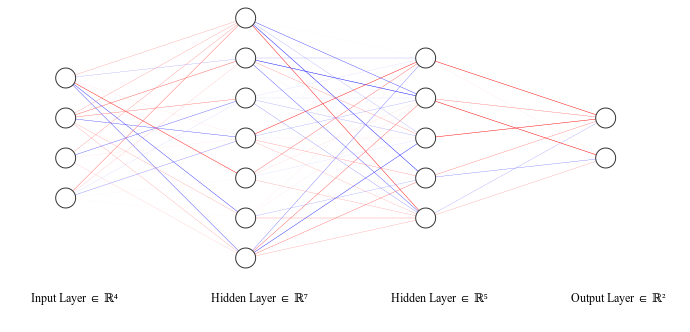

In [8]:
X = torch.rand(1,26, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=-1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3], device='cuda:0')


In [9]:
import copy

def train_nn(num_epochs, optimizer, dataloader, loss_fn, model, learning_rate):
    # copy by value the model
    model_copy = copy.deepcopy(model)
    model_copy.train()
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate)
    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        size = len(dataloader.dataset)
        for batch, (X, y) in enumerate(dataloader):

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)
            # loss_fn defined above to be  nn.CrossEntropyLoss()
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # updating the weights of neural network

            # per batch report the value of the loss function on the training set
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return model_copy

In [10]:
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.2 MB/s 


In [11]:
from torchmetrics.functional import f1_score

def test_nn(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    # initialize the loss function
    loss = 0
    # initialize the number of correct predictions
    correct = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(4, 4)
    # initialize the f1 score
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            _, preds = torch.max(pred, 1)
            for t, p in zip(y.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    loss /= size
    correct /= size
    # calculate f1 macro averaged
    f1 = f1_score(pred, y, num_classes=4, average='macro')
    # calculate confusion matrix
    return loss, f1.item(), correct, confusion_matrix

In [12]:
# define the loss function
loss_fn = nn.CrossEntropyLoss()
# define the hyperparameters of the optimization/training process
learning_rate = 2e-3
num_epochs = 30
# define the optimizer object
# Stochastic Gradient Descent
optimizer = torch.optim.SGD

In [13]:
model1 = train_nn(num_epochs, optimizer, train_dataloader, loss_fn, model, learning_rate)
print(model1)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.321976  [  928/ 3200]
loss: 1.346422  [  944/ 3200]
loss: 1.347357  [  960/ 3200]
loss: 1.299327  [  976/ 3200]
loss: 1.311090  [  992/ 3200]
loss: 1.309946  [ 1008/ 3200]
loss: 1.352619  [ 1024/ 3200]
loss: 1.369092  [ 1040/ 3200]
loss: 1.348496  [ 1056/ 3200]
loss: 1.354751  [ 1072/ 3200]
loss: 1.326494  [ 1088/ 3200]
loss: 1.368757  [ 1104/ 3200]
loss: 1.313691  [ 1120/ 3200]
loss: 1.371408  [ 1136/ 3200]
loss: 1.325421  [ 1152/ 3200]
loss: 1.356895  [ 1168/ 3200]
loss: 1.347346  [ 1184/ 3200]
loss: 1.350955  [ 1200/ 3200]
loss: 1.382154  [ 1216/ 3200]
loss: 1.309241  [ 1232/ 3200]
loss: 1.361070  [ 1248/ 3200]
loss: 1.320360  [ 1264/ 3200]
loss: 1.327271  [ 1280/ 3200]
loss: 1.351011  [ 1296/ 3200]
loss: 1.325349  [ 1312/ 3200]
loss: 1.347853  [ 1328/ 3200]
loss: 1.344605  [ 1344/ 3200]
loss: 1.357755  [ 1360/ 3200]
loss: 1.378933  [ 1376/ 3200]
loss: 1.352506  [ 1392/ 3200]
loss: 1.329163  [ 1408/ 3200]
loss: 1.329754 

In [14]:
test_nn(test_dataloader, model1, loss_fn)

(0.0007137712091207504,
 0.5377352237701416,
 0.5850290697674418,
 tensor([[ 24.,  24.,  87., 189.],
         [ 16., 218.,  15.,  48.],
         [ 24.,  14., 231.,  87.],
         [ 14.,  17.,  36., 332.]]))

In [15]:
def choose_model(num_epochs, optimizer, train, loss_fn, model, learning_rate, val):
    # copy by value the model
    model_copy = copy.deepcopy(model)
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate)
    f1_max = 0
    for e in range(num_epochs):
        model_copy.train()
        for (data, label) in train:

            # if using gpu dont forget to move the data there
            data = data.to(device)
            label = label.to(device)

            # Compute prediction and loss
            target = model_copy(data)
            # loss_fn defined above to be  nn.CrossEntropyLoss()
            loss = loss_fn(target, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # updating the weights of neural network

        train_f1 = f1_score(target, label, num_classes=4, average='macro')

        model_copy.eval()
        for (X, y) in val:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)

        val_f1 = f1_score(pred, y, num_classes=4, average='macro')

        
        print(f'Epoch {e+1} \t\t Training f1: {train_f1} \t\t Validation f1: {val_f1}')


        if f1_max < val_f1:
            print(f'Validation f1 Increased({f1_max:.6f}--->{val_f1:.6f}) \t Saving The Model')
            f1_max = val_f1
            # Saving State Dict
            torch.save(model_copy.state_dict(), 'optimal.pth')
    torch.save(model_copy.state_dict(), 'last.pth')
    print('-----------------------------------------------------')
    print(f'f1 optimal: {f1_max:.6f} \nf1 train at end of epoch: {train_f1:.6f}')

In [16]:
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, model, learning_rate, val_dataloader)

Epoch 1 		 Training f1: 0.22692307829856873 		 Validation f1: 0.2544112801551819
Validation f1 Increased(0.000000--->0.254411) 	 Saving The Model
Epoch 2 		 Training f1: 0.13636364042758942 		 Validation f1: 0.10258766263723373
Epoch 3 		 Training f1: 0.1964285671710968 		 Validation f1: 0.45308488607406616
Validation f1 Increased(0.254411--->0.453085) 	 Saving The Model
Epoch 4 		 Training f1: 0.36666667461395264 		 Validation f1: 0.17432507872581482
Epoch 5 		 Training f1: 0.28131866455078125 		 Validation f1: 0.48506635427474976
Validation f1 Increased(0.453085--->0.485066) 	 Saving The Model
Epoch 6 		 Training f1: 0.14215686917304993 		 Validation f1: 0.3554023802280426
Epoch 7 		 Training f1: 0.38611114025115967 		 Validation f1: 0.4987509250640869
Validation f1 Increased(0.485066--->0.498751) 	 Saving The Model
Epoch 8 		 Training f1: 0.3743131756782532 		 Validation f1: 0.5737300515174866
Validation f1 Increased(0.498751--->0.573730) 	 Saving The Model
Epoch 9 		 Training f1: 0

In [17]:
last_model = NeuralNetwork().to(device)
last_model.load_state_dict(torch.load('last.pth'))

<All keys matched successfully>

In [18]:
optimal_model = NeuralNetwork().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))

<All keys matched successfully>

In [19]:
print(test_nn(test_dataloader, last_model, loss_fn))
print(test_nn(test_dataloader, optimal_model, loss_fn))

(0.0007050397351037624, 0.5754448175430298, 0.6184593023255814, tensor([[ 41.,  27., 127., 129.],
        [ 20., 226.,  22.,  29.],
        [ 18.,  16., 286.,  36.],
        [ 21.,  28.,  52., 298.]]))
(0.0007182826656241749, 0.6009374856948853, 0.6206395348837209, tensor([[ 84.,  45.,  89., 106.],
        [ 26., 249.,  11.,  11.],
        [ 47.,  27., 254.,  28.],
        [ 44.,  47.,  41., 267.]]))


In [20]:
rep = 'melgrams'

training_data = CustomDataset(npy_loader(get_path('train', rep, 0)), npy_loader(get_path('train', rep, 1)))
val_data = CustomDataset(npy_loader(get_path('val', rep, 0)), npy_loader(get_path('val', rep, 1)))
test_data = CustomDataset(npy_loader(get_path('test', rep, 0)), npy_loader(get_path('test', rep, 1)))

batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=800, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1376, shuffle=False)

print(training_data[0][0].shape)

torch.Size([1, 21, 128])


In [21]:
import random

def get_random_id_from_class(i):
	while True:
		idx = random.randint(0, len(training_data)-1)
		if training_data[idx][1] == i:
			return idx

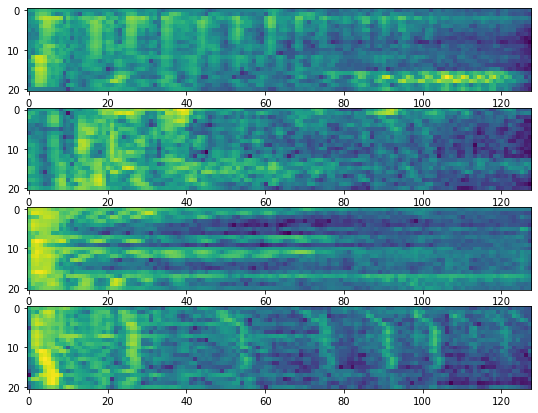

In [22]:
import matplotlib.pyplot as plt

# Visualize a random melgram from each class
plt.figure(figsize=(15,7))
for i in range(4):
	plt.subplot(4, 1, i+1)
	image = training_data[get_random_id_from_class(i)][0].numpy()
	image = np.squeeze(image, axis=0)
	plt.imshow(image)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [24]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # fully connected layers
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self, x):
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.max_pool(F.relu(self.conv3(x)))
    x = self.max_pool(F.relu(self.conv4(x)))
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

net = LeNet().to(device)

# define the corresponding loss function and the optimizer
learning_rate = 1e-3
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam

In [25]:
def choose_model(num_epochs, optimizer, train, loss_fn, model, learning_rate, val, reproducibility=False, show=True, lbfgs=False):
    # set seed before create your model  
    if reproducibility:
        torch_seed(seed=0)
    
    # copy by value the model
    model_copy = copy.deepcopy(model)
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate)
    f1_max = 0
    for e in range(num_epochs):
        model_copy.train()
        for (data, label) in train:

            # if using gpu dont forget to move the data there
            data = data.to(device)
            label = label.to(device)

            def closure():
                optimizer.zero_grad()
                target = model_copy(data)
                loss = loss_fn(target, label)
                loss.backward()
                return loss
            if lbfgs:
                optimizer.step(closure)
                target = model_copy(data)
            else:
                # Compute prediction and loss
                target = model_copy(data)
                # loss_fn defined above to be  nn.CrossEntropyLoss()
                loss = loss_fn(target, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() # updating the weights of neural network

        train_f1 = f1_score(target, label, num_classes=4, average='macro')

        model_copy.eval()
        for (X, y) in val:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)

        val_f1 = f1_score(pred, y, num_classes=4, average='macro')

        if show:
            print(f'Epoch {e+1} \t\t Training f1: {train_f1} \t\t Validation f1: {val_f1}', end='')
            if (reproducibility):
                print(f'\t\t Loss: {loss}')
            else:
                print()


        if f1_max < val_f1:
            if show:
                print(f'Validation f1 Increased({f1_max:.6f}--->{val_f1:.6f}) \t Saving The Model')
            f1_max = val_f1
            # Saving State Dict
            torch.save(model_copy.state_dict(), 'optimal.pth')
    torch.save(model_copy.state_dict(), 'last.pth')
    if show:
        print('-----------------------------------------------------')
        print(f'f1 optimal: {f1_max:.6f} \nf1 train at end of epoch: {train_f1:.6f}')

In [26]:
from torchmetrics.functional import f1_score

def test_nn(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    # initialize the loss function
    loss = 0
    # initialize the number of correct predictions
    correct = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(4, 4)
    # initialize the f1 score
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            _, preds = torch.max(pred, 1)
            for t, p in zip(y.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    loss /= size
    correct /= size
    # calculate f1 macro averaged
    f1 = f1_score(pred, y, num_classes=4, average='macro')
    # calculate confusion matrix
    return loss, f1.item(), correct, confusion_matrix

In [27]:
num_epochs = 30
choose_model(num_epochs, optimizer_1, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader)

Epoch 1 		 Training f1: 0.3639705777168274 		 Validation f1: 0.4182340204715729
Validation f1 Increased(0.000000--->0.418234) 	 Saving The Model
Epoch 2 		 Training f1: 0.3102564215660095 		 Validation f1: 0.4746589958667755
Validation f1 Increased(0.418234--->0.474659) 	 Saving The Model
Epoch 3 		 Training f1: 0.740079402923584 		 Validation f1: 0.5961748361587524
Validation f1 Increased(0.474659--->0.596175) 	 Saving The Model
Epoch 4 		 Training f1: 0.3333333432674408 		 Validation f1: 0.45436084270477295
Epoch 5 		 Training f1: 0.5198413133621216 		 Validation f1: 0.6479859352111816
Validation f1 Increased(0.596175--->0.647986) 	 Saving The Model
Epoch 6 		 Training f1: 0.7984848618507385 		 Validation f1: 0.7224270105361938
Validation f1 Increased(0.647986--->0.722427) 	 Saving The Model
Epoch 7 		 Training f1: 0.8687499761581421 		 Validation f1: 0.7267510294914246
Validation f1 Increased(0.722427--->0.726751) 	 Saving The Model
Epoch 8 		 Training f1: 0.8309524059295654 		 Vali

In [28]:
optimal_model = LeNet().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))

<All keys matched successfully>

In [29]:
print(test_nn(test_dataloader, optimal_model, loss_fn))

(0.0005381266738093177, 0.7114886045455933, 0.7093023255813954, tensor([[203.,  42.,  14.,  65.],
        [  6., 287.,   1.,   3.],
        [ 26.,   9., 279.,  42.],
        [121.,  30.,  41., 207.]]))


In [ ]:
Algorithms = ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'LBFGS', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD']

In [ ]:
from tabulate import tabulate

temp = [['Algorithms', 'Accuracy (%)', 'f1']]
for a in Algorithms:
	net = LeNet().to(device)
	optimizer = getattr(optim, a)
	if a == 'LBFGS':
		choose_model(num_epochs, optimizer, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader, show=False, lbfgs=True)
	else:
		choose_model(num_epochs, optimizer, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader, show=False)
	optimal_model = LeNet().to(device)
	optimal_model.load_state_dict(torch.load('optimal.pth'))
	_, f1, accuracy, _ = test_nn(test_dataloader, optimal_model, loss_fn_1)
	temp.append([a, accuracy*100, f1])

rotated = [[None for j in range(len(temp))] for i in range(3)]
for i, row in enumerate(temp):
    for j, value in enumerate(row):
        rotated[j][i] = value

print(tabulate(rotated, tablefmt="fancy_grid"))

╒══════════════╤═════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╤═════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Algorithms   │ Adadelta            │ Adagrad            │ Adam               │ AdamW              │ Adamax             │ ASGD               │ LBFGS               │ NAdam              │ RAdam              │ RMSprop            │ Rprop              │ SGD                │
├──────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Accuracy (%) │ 49.41860465116279   │ 74.63662790697676  │ 69.18604651162791  │ 71.51162790697676  │ 74.70930232558139  │ 69.11337209302324  │ 22.819767441860463  │ 67.07848837209302  │ 

In [30]:
import random, os

In [31]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [32]:
num_epochs = 30
optimizer_1 = optim.Adam
choose_model(num_epochs, optimizer_1, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader, reproducibility=True)
optimal_model = LeNet().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training f1: 0.45384615659713745 		 Validation f1: 0.4746466279029846		 Loss: 0.8585479259490967
Validation f1 Increased(0.000000--->0.474647) 	 Saving The Model
Epoch 2 		 Training f1: 0.7142857313156128 		 Validation f1: 0.5901783108711243		 Loss: 0.647953987121582
Validation f1 Increased(0.474647--->0.590178) 	 Saving The Model
Epoch 3 		 Training f1: 0.7003968358039856 		 Validation f1: 0.6463372707366943		 Loss: 0.6502941846847534
Validation f1 Increased(0.590178--->0.646337) 	 Saving The Model
Epoch 4 		 Training f1: 0.8439394235610962 		 Validation f1: 0.6773467063903809		 Loss: 0.5651968121528625
Validation f1 Increased(0.646337--->0.677347) 	 Saving The Model
Epoch 5 		 Training f1: 0.622619092464447 		 Validation f1: 0.6677638292312622		 Loss: 0.5089439153671265
Epoch 6 		 Training f1: 0.6788420081138611 		 Validation f1: 0.665547251701355		 Loss: 0.8748731017112732
Epoch 7 		 Training f1: 0.7756410241127014 		 Validation f1: 0.6426476240158081		 Loss: 0.5718334317

In [33]:
num_epochs = 30
optimizer_1 = optim.Adam
choose_model(num_epochs, optimizer_1, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader, reproducibility=True)
optimal_model = LeNet().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training f1: 0.45384615659713745 		 Validation f1: 0.4746466279029846		 Loss: 0.8585479259490967
Validation f1 Increased(0.000000--->0.474647) 	 Saving The Model
Epoch 2 		 Training f1: 0.7142857313156128 		 Validation f1: 0.5901783108711243		 Loss: 0.647953987121582
Validation f1 Increased(0.474647--->0.590178) 	 Saving The Model
Epoch 3 		 Training f1: 0.7003968358039856 		 Validation f1: 0.6463372707366943		 Loss: 0.6502941846847534
Validation f1 Increased(0.590178--->0.646337) 	 Saving The Model
Epoch 4 		 Training f1: 0.8439394235610962 		 Validation f1: 0.6773467063903809		 Loss: 0.5651968121528625
Validation f1 Increased(0.646337--->0.677347) 	 Saving The Model
Epoch 5 		 Training f1: 0.622619092464447 		 Validation f1: 0.6677638292312622		 Loss: 0.5089439153671265
Epoch 6 		 Training f1: 0.6788420081138611 		 Validation f1: 0.665547251701355		 Loss: 0.8748731017112732
Epoch 7 		 Training f1: 0.7756410241127014 		 Validation f1: 0.6426476240158081		 Loss: 0.5718334317

In [ ]:
class LeNet(nn.Module):
  def __init__(self, fun):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # fully connected layers
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

    self.fun = fun

  def forward(self, x):
    if self.fun.__name__.lower() == 'leakyrelu':
      fun = getattr(F, 'leaky_relu')
    elif self.fun.__name__.lower() == 'sigmoid':
      fun = getattr(torch, 'sigmoid')
    elif self.fun.__name__.lower() == 'tanh':
      fun = getattr(torch, 'tanh')
    else:
      fun = getattr(F, self.fun.__name__.lower())
    x = self.max_pool(fun(self.conv1(x)))
    x = self.max_pool(fun(self.conv2(x)))
    x = self.max_pool(fun(self.conv3(x)))
    x = self.max_pool(fun(self.conv4(x)))
    x = x.view(x.size(0), -1)

    x = fun(self.fc1(x))
    x = fun(self.fc2(x))
    x = fun(self.fc3(x))
    x = fun(self.fc4(x))
    return x

In [ ]:
NLAF = ['ELU', 'Hardshrink', 'Hardsigmoid', 'Hardtanh', 'Hardswish', 'LeakyReLU', 'LogSigmoid', 'ReLU', 'ReLU6', 'RReLU', 'SELU', 'CELU', 'GELU', 'Sigmoid', 'SiLU', 'Mish', 'Softplus', 'Softshrink', 'Softsign', 'Tanh', 'Tanhshrink']

In [ ]:
from tabulate import tabulate

temp = [['Activation functions', 'f1', 'Accuracy (%)']]
for a in NLAF:
    print(a)
    atr = getattr(nn, a)
    net = LeNet(atr).to(device)
    choose_model(num_epochs, optimizer_1, train_dataloader, loss_fn_1, net, learning_rate, val_dataloader, show=False, reproducibility=True)
    optimal_model = LeNet(atr).to(device)
    optimal_model.load_state_dict(torch.load('optimal.pth'))
    _, f1, accuracy, _ = test_nn(test_dataloader, optimal_model, loss_fn_1)
    temp.append([a, f1, accuracy*100])

print(tabulate(temp, tablefmt="fancy_grid"))

ELU
Hardshrink
Hardsigmoid
Hardtanh
Hardswish
LeakyReLU
LogSigmoid
ReLU
ReLU6
RReLU
SELU
CELU
GELU
Sigmoid
SiLU
Mish
Softplus
Softshrink
Softsign
Tanh
Tanhshrink
╒══════════════════════╤═════════════════════╤════════════════════╕
│ Activation functions │ f1                  │ Accuracy (%)       │
├──────────────────────┼─────────────────────┼────────────────────┤
│ ELU                  │ 0.14176298677921295 │ 22.238372093023255 │
├──────────────────────┼─────────────────────┼────────────────────┤
│ Hardshrink           │ 0.3045373857021332  │ 38.08139534883721  │
├──────────────────────┼─────────────────────┼────────────────────┤
│ Hardsigmoid          │ 0.10277137160301208 │ 25.872093023255815 │
├──────────────────────┼─────────────────────┼────────────────────┤
│ Hardtanh             │ 0.09529411792755127 │ 23.546511627906977 │
├──────────────────────┼─────────────────────┼────────────────────┤
│ Hardswish            │ 0.7175038456916809  │ 71.58430232558139  │
├─────────────────────

In [ ]:
def choose_model(num_epochs, optimizer, train, loss_fn, model, learning_rate, val, reproducibility=False, show=True, lbfgs=False, scheduler=None, verbose=False):
    # set seed before create your model  
    if reproducibility:
        torch_seed(seed=0)
    
    # copy by value the model
    model_copy = copy.deepcopy(model)
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate)
    if scheduler != None:
      if scheduler == torch.optim.lr_scheduler.ExponentialLR:
        scheduler = scheduler(optimizer, gamma=0.9, verbose=verbose)
      elif scheduler == torch.optim.lr_scheduler.LambdaLR or scheduler == torch.optim.lr_scheduler.MultiplicativeLR:
        lmbda = lambda epoch: 0.95
        scheduler = scheduler(optimizer, verbose=verbose, lr_lambda=lmbda)
      elif scheduler == torch.optim.lr_scheduler.StepLR:
        scheduler = scheduler(optimizer, step_size=30, gamma=0.1, verbose=verbose)
      elif scheduler == torch.optim.lr_scheduler.MultiStepLR:
        scheduler = scheduler(optimizer, milestones=[30], verbose=verbose)
      elif scheduler == torch.optim.lr_scheduler.CosineAnnealingLR:
        scheduler = scheduler(optimizer, T_max=30, verbose=verbose)
      elif scheduler == torch.optim.lr_scheduler.ChainedScheduler:
        scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2)
        scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        scheduler = scheduler([scheduler1, scheduler2])
      elif scheduler == torch.optim.lr_scheduler.CyclicLR:
        scheduler = scheduler(optimizer, base_lr=0.01, max_lr=0.1, verbose=verbose)
      else:
        scheduler = scheduler(optimizer, verbose=verbose)
    f1_max = 0
    for e in range(num_epochs):
        model_copy.train()
        for (data, label) in train:

            # if using gpu dont forget to move the data there
            data = data.to(device)
            label = label.to(device)

            def closure():
                optimizer.zero_grad()
                target = model_copy(data)
                loss = loss_fn(target, label)
                loss.backward()
                return loss
            if lbfgs:
                optimizer.step(closure)
                target = model_copy(data)
            else:
                # Compute prediction and loss
                target = model_copy(data)
                # loss_fn defined above to be  nn.CrossEntropyLoss()
                loss = loss_fn(target, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() # updating the weights of neural network

        if scheduler != None:
          scheduler.step()

        train_f1 = f1_score(target, label, num_classes=4, average='macro')

        model_copy.eval()
        for (X, y) in val:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)

        val_f1 = f1_score(pred, y, num_classes=4, average='macro')

        if show:
            print(f'Epoch {e+1} \t\t Training f1: {train_f1} \t\t Validation f1: {val_f1}', end='')
            if (reproducibility):
                print(f'\t\t Loss: {loss}')
            else:
                print()


        if f1_max < val_f1:
            if show:
                print(f'Validation f1 Increased({f1_max:.6f}--->{val_f1:.6f}) \t Saving The Model')
            f1_max = val_f1
            # Saving State Dict
            torch.save(model_copy.state_dict(), 'optimal.pth')
    torch.save(model_copy.state_dict(), 'last.pth')
    if show:
        print('-----------------------------------------------------')
        print(f'f1 optimal: {f1_max:.6f} \nf1 train at end of epoch: {train_f1:.6f}')

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

num_epochs = 30
optimizer = optim.Adam
scheduler = ExponentialLR
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net, learning_rate, val_dataloader, reproducibility=True, show = False, scheduler=scheduler, verbose = True)
optimal_model = LeNet().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.8000e-03.
Adjusting learning rate of group 0 to 1.6200e-03.
Adjusting learning rate of group 0 to 1.4580e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.0629e-03.
Adjusting learning rate of group 0 to 9.5659e-04.
Adjusting learning rate of group 0 to 8.6093e-04.
Adjusting learning rate of group 0 to 7.7484e-04.
Adjusting learning rate of group 0 to 6.9736e-04.
Adjusting learning rate of group 0 to 6.2762e-04.
Adjusting learning rate of group 0 to 5.6486e-04.
Adjusting learning rate of group 0 to 5.0837e-04.
Adjusting learning rate of group 0 to 4.5754e-04.
Adjusting learning rate of group 0 to 4.1178e-04.
Adjusting learning rate of group 0 to 3.7060e-04.
Adjusting learning rate of group 0 to 3.3354e-04.
Adjusting learning rate of group 0 to 3.0019e-04.
Adjusting learning rate of group 0 to 2.7017e-04.


In [ ]:
sch = ['LambdaLR', 'MultiplicativeLR', 'StepLR', 'MultiStepLR', 'ConstantLR', 'LinearLR', 'ExponentialLR', 'CosineAnnealingLR', 'ChainedScheduler']

In [ ]:
from tabulate import tabulate

temp = [['Schedulers', 'f1', 'Accuracy (%)']]
for a in sch:
    print(a)
    atr = getattr(torch.optim.lr_scheduler, a)
    net = LeNet().to(device)
    choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net, learning_rate, val_dataloader, show=False, reproducibility=True, scheduler = atr)
    optimal_model = LeNet().to(device)
    optimal_model.load_state_dict(torch.load('optimal.pth'))
    _, f1, accuracy, _ = test_nn(test_dataloader, optimal_model, loss_fn_1)
    temp.append([a, f1, accuracy*100])

print(tabulate(temp, tablefmt="fancy_grid"))

LambdaLR
MultiplicativeLR
StepLR
MultiStepLR
ConstantLR
LinearLR
ExponentialLR
CosineAnnealingLR
ChainedScheduler
╒═══════════════════╤════════════════════╤═══════════════════╕
│ Schedulers        │ f1                 │ Accuracy (%)      │
├───────────────────┼────────────────────┼───────────────────┤
│ LambdaLR          │ 0.6959515810012817 │ 69.3313953488372  │
├───────────────────┼────────────────────┼───────────────────┤
│ MultiplicativeLR  │ 0.6795541644096375 │ 66.86046511627907 │
├───────────────────┼────────────────────┼───────────────────┤
│ StepLR            │ 0.6766413450241089 │ 67.44186046511628 │
├───────────────────┼────────────────────┼───────────────────┤
│ MultiStepLR       │ 0.6766413450241089 │ 67.44186046511628 │
├───────────────────┼────────────────────┼───────────────────┤
│ ConstantLR        │ 0.700812816619873  │ 69.98546511627907 │
├───────────────────┼────────────────────┼───────────────────┤
│ LinearLR          │ 0.7183283567428589 │ 71.51162790697676 │
├───

In [41]:
class LeNet1(nn.Module):
  def __init__(self):
    super(LeNet1, self).__init__()
    self.convolution_layer = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(16, 32, kernel_size=5, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 128, kernel_size=5, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.linear_relu = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
        nn.ReLU(),
        nn.Linear(32, 4),
    )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits = self.linear_relu(x)
    return logits

net1 = LeNet1().to(device)


In [ ]:
num_epochs = 30
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net1, learning_rate, val_dataloader, reproducibility=True, show = False)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

(0.000669376231556715, 0.7792076468467712, 0.7747093023255814, tensor([[230.,  10.,  38.,  46.],
        [ 19., 270.,   4.,   4.],
        [ 16.,   1., 317.,  22.],
        [102.,  12.,  36., 249.]]))


In [ ]:
def choose_model(num_epochs, optimizer, train, loss_fn, model, learning_rate, val, reproducibility=False, wd=0.0, show=True, lbfgs=False):
    # set seed before create your model  
    if reproducibility:
        torch_seed(seed=0)
    
    # copy by value the model
    model_copy = copy.deepcopy(model)
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate, weight_decay=wd )
    f1_max = 0
    for e in range(num_epochs):
        train_loss = 0.0
        model_copy.train()
        for (data, label) in train:

            # if using gpu dont forget to move the data there
            data = data.to(device)
            label = label.to(device)

            def closure():
                optimizer.zero_grad()
                target = model_copy(data)
                loss = loss_fn(target, label)
                loss.backward()
                return loss
            if lbfgs:
                optimizer.step(closure)
                target = model_copy(data)
            else:
                # Compute prediction and loss
                target = model_copy(data)
                # loss_fn defined above to be  nn.CrossEntropyLoss()
                loss = loss_fn(target, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() # updating the weights of neural network
                train_loss += loss.item()

        train_f1 = f1_score(target, label, num_classes=4, average='macro')

        valid_loss = 0.0
        model_copy.eval()
        for (X, y) in val:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)

            loss = loss_fn(pred, y)
            valid_loss += loss.item()

        val_f1 = f1_score(pred, y, num_classes=4, average='macro')

        if show:
            print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train)} \t\t Validation Loss: {valid_loss / len(val)}')


        if f1_max < val_f1:
            f1_max = val_f1
            # Saving State Dict
            torch.save(model_copy.state_dict(), 'optimal.pth')
    torch.save(model_copy.state_dict(), 'last.pth')

In [ ]:
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net1, learning_rate, val_dataloader, reproducibility=True)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.0227228454500437 		 Validation Loss: 0.9796355366706848
Epoch 2 		 Training Loss: 0.759075411260128 		 Validation Loss: 0.7287921905517578
Epoch 3 		 Training Loss: 0.6666638664901257 		 Validation Loss: 0.8450986742973328
Epoch 4 		 Training Loss: 0.6045088172703982 		 Validation Loss: 0.7578967809677124
Epoch 5 		 Training Loss: 0.5483834965899587 		 Validation Loss: 0.9878327250480652
Epoch 6 		 Training Loss: 0.5044965025037527 		 Validation Loss: 0.8449056148529053
Epoch 7 		 Training Loss: 0.49651616752147676 		 Validation Loss: 1.1259151697158813
Epoch 8 		 Training Loss: 0.43058030627667904 		 Validation Loss: 0.5439536571502686
Epoch 9 		 Training Loss: 0.4044629971310496 		 Validation Loss: 2.6772091388702393
Epoch 10 		 Training Loss: 0.41922647718340156 		 Validation Loss: 0.9468997716903687
Epoch 11 		 Training Loss: 0.3464579423330724 		 Validation Loss: 0.9095437526702881
Epoch 12 		 Training Loss: 0.3236820953898132 		 Validation Loss: 0.6053

In [ ]:
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net1, learning_rate, val_dataloader, reproducibility=True, wd=0.05)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.1940588575601578 		 Validation Loss: 1.1537491083145142
Epoch 2 		 Training Loss: 1.0899036577343941 		 Validation Loss: 9.296834945678711
Epoch 3 		 Training Loss: 1.0222694870829583 		 Validation Loss: 1.2506409883499146
Epoch 4 		 Training Loss: 0.9714676383137703 		 Validation Loss: 0.943543553352356
Epoch 5 		 Training Loss: 0.9301613396406174 		 Validation Loss: 0.9249820709228516
Epoch 6 		 Training Loss: 0.9124936556816101 		 Validation Loss: 1.107026219367981
Epoch 7 		 Training Loss: 0.874731510579586 		 Validation Loss: 2.1015889644622803
Epoch 8 		 Training Loss: 0.8625895711779594 		 Validation Loss: 0.8712542653083801
Epoch 9 		 Training Loss: 0.8551184546947479 		 Validation Loss: 0.8063517808914185
Epoch 10 		 Training Loss: 0.8429585041105747 		 Validation Loss: 0.7877652049064636
Epoch 11 		 Training Loss: 0.8394316101074218 		 Validation Loss: 0.814486563205719
Epoch 12 		 Training Loss: 0.8336206349730492 		 Validation Loss: 0.87210136651

In [ ]:
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net1, learning_rate, val_dataloader, reproducibility=True, wd=0.1)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.3811385637521745 		 Validation Loss: 1.38637113571167
Epoch 2 		 Training Loss: 1.386584571003914 		 Validation Loss: 1.3863071203231812
Epoch 3 		 Training Loss: 1.386584106683731 		 Validation Loss: 1.3863036632537842
Epoch 4 		 Training Loss: 1.3866084283590316 		 Validation Loss: 1.3863126039505005
Epoch 5 		 Training Loss: 1.3865894573926925 		 Validation Loss: 1.3863091468811035
Epoch 6 		 Training Loss: 1.3865668588876725 		 Validation Loss: 1.3863497972488403
Epoch 7 		 Training Loss: 1.386678120493889 		 Validation Loss: 1.3862981796264648
Epoch 8 		 Training Loss: 1.3866682326793671 		 Validation Loss: 1.3863105773925781
Epoch 9 		 Training Loss: 1.3867467308044434 		 Validation Loss: 1.3863019943237305
Epoch 10 		 Training Loss: 1.3866607224941254 		 Validation Loss: 1.3863083124160767
Epoch 11 		 Training Loss: 1.3866775476932525 		 Validation Loss: 1.3863006830215454
Epoch 12 		 Training Loss: 1.3866899460554123 		 Validation Loss: 1.38630354404

In [34]:
class LeNetDrop(nn.Module):
  def __init__(self, do):
    super(LeNetDrop, self).__init__()
    self.convolution_layer = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(16, 32, kernel_size=5, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 128, kernel_size=5, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.linear_relu = nn.Sequential(
        nn.Dropout(do),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Dropout(do),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(do),
        nn.Linear(256, 32),
        nn.ReLU(),
        nn.Dropout(do),
        nn.Linear(32, 4),
    )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits = self.linear_relu(x)
    return logits


In [ ]:
do = 0.5
net2 = LeNetDrop(do).to(device)
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, reproducibility=True)
optimal_model = LeNetDrop(do).to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.321156659722328 		 Validation Loss: 1.1661072969436646
Epoch 2 		 Training Loss: 1.23952639490366 		 Validation Loss: 1.1802884340286255
Epoch 3 		 Training Loss: 1.1338506725430488 		 Validation Loss: 1.5577853918075562
Epoch 4 		 Training Loss: 0.9656573216617107 		 Validation Loss: 1.7948826551437378
Epoch 5 		 Training Loss: 0.9202900639176369 		 Validation Loss: 2.8437509536743164
Epoch 6 		 Training Loss: 0.8378933982551098 		 Validation Loss: 0.6299632787704468
Epoch 7 		 Training Loss: 0.773862941712141 		 Validation Loss: 0.7210538387298584
Epoch 8 		 Training Loss: 0.7453544361144304 		 Validation Loss: 0.6883983016014099
Epoch 9 		 Training Loss: 0.7253496524691582 		 Validation Loss: 0.5949004888534546
Epoch 10 		 Training Loss: 0.7558138680458069 		 Validation Loss: 0.9200499057769775
Epoch 11 		 Training Loss: 0.6716405886411667 		 Validation Loss: 0.7231597900390625
Epoch 12 		 Training Loss: 0.6441356351971627 		 Validation Loss: 0.7933148145

In [ ]:
do = 1.0
net2 = LeNetDrop(do).to(device)
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, reproducibility=True)
optimal_model = LeNetDrop(do).to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.38892962038517 		 Validation Loss: 1.387092113494873
Epoch 2 		 Training Loss: 1.3869564533233643 		 Validation Loss: 1.3865749835968018
Epoch 3 		 Training Loss: 1.386660338640213 		 Validation Loss: 1.3864895105361938
Epoch 4 		 Training Loss: 1.3866508907079698 		 Validation Loss: 1.386462688446045
Epoch 5 		 Training Loss: 1.3866078811883926 		 Validation Loss: 1.3865405321121216
Epoch 6 		 Training Loss: 1.3866335201263427 		 Validation Loss: 1.3866324424743652
Epoch 7 		 Training Loss: 1.3867101287841797 		 Validation Loss: 1.386509895324707
Epoch 8 		 Training Loss: 1.386686868071556 		 Validation Loss: 1.3866510391235352
Epoch 9 		 Training Loss: 1.3867610388994216 		 Validation Loss: 1.3865089416503906
Epoch 10 		 Training Loss: 1.386669105887413 		 Validation Loss: 1.3865808248519897
Epoch 11 		 Training Loss: 1.3866918116807938 		 Validation Loss: 1.3865526914596558
Epoch 12 		 Training Loss: 1.3867379987239838 		 Validation Loss: 1.38654673099517

In [ ]:
do = 0.5
net2 = LeNetDrop(do).to(device)
num_epochs = 60
optimizer = optim.Adam
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3
choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, reproducibility=True, wd=0.05)
optimal_model = LeNetDrop(do).to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
print(test_nn(test_dataloader, optimal_model, loss_fn))

Epoch 1 		 Training Loss: 1.2335909938812255 		 Validation Loss: 1.3385474681854248
Epoch 2 		 Training Loss: 1.1894449400901794 		 Validation Loss: 1.4474892616271973
Epoch 3 		 Training Loss: 1.1453183922171593 		 Validation Loss: 1.1718875169754028
Epoch 4 		 Training Loss: 1.1020587733387948 		 Validation Loss: 1.0539872646331787
Epoch 5 		 Training Loss: 1.0652547317743302 		 Validation Loss: 0.9664693474769592
Epoch 6 		 Training Loss: 1.0343206685781479 		 Validation Loss: 1.0430060625076294
Epoch 7 		 Training Loss: 1.0098350906372071 		 Validation Loss: 0.9287013411521912
Epoch 8 		 Training Loss: 1.0030429551005364 		 Validation Loss: 1.0003821849822998
Epoch 9 		 Training Loss: 1.0298863199353219 		 Validation Loss: 0.9350055456161499
Epoch 10 		 Training Loss: 0.9551158028841019 		 Validation Loss: 0.8740501999855042
Epoch 11 		 Training Loss: 0.9528282302618026 		 Validation Loss: 0.9858938455581665
Epoch 12 		 Training Loss: 0.9597271606326103 		 Validation Loss: 0.936445

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    # fully connected layers
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self, x):
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.max_pool(F.relu(self.conv3(x)))
    x = self.max_pool(F.relu(self.conv4(x)))
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

net = LeNet().to(device)

# define the corresponding loss function and the optimizer
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam
num_epochs = 30

In [ ]:
for i in range(1,8):
    batch_size = 2**i

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    import time

    start = time.time()

    choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, reproducibility=True, show=False)
    optimal_model = LeNetDrop(do).to(device)
    optimal_model.load_state_dict(torch.load('optimal.pth'))
    _, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)

    end = time.time()

    print('Batch_size: ', batch_size, '\t Performance: ', apodosi, '\t Time elapsed: ', end-start)


Batch_size:  2 	 Performance:  0.3333333432674408 	 Time elapsed:  316.5172836780548
Batch_size:  4 	 Performance:  0.0 	 Time elapsed:  159.71120071411133
Batch_size:  8 	 Performance:  0.1818181872367859 	 Time elapsed:  83.73017811775208
Batch_size:  16 	 Performance:  0.2988505959510803 	 Time elapsed:  42.598090171813965
Batch_size:  32 	 Performance:  0.2380952388048172 	 Time elapsed:  23.94163155555725
Batch_size:  64 	 Performance:  0.3962264060974121 	 Time elapsed:  16.616625547409058
Batch_size:  128 	 Performance:  0.14179104566574097 	 Time elapsed:  13.11973261833191


In [ ]:
for i in range(1,8):
    batch_size = 2**i

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=800, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1376, shuffle=False)

    import time

    start = time.time()

    choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, reproducibility=True, show=False)
    optimal_model = LeNetDrop(do).to(device)
    optimal_model.load_state_dict(torch.load('optimal.pth'))
    _, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)

    end = time.time()

    print('Batch_size: ', batch_size, '\t Performance: ', apodosi, '\t Time elapsed: ', end-start)


Batch_size:  2 	 Performance:  0.7868454456329346 	 Time elapsed:  286.3442385196686
Batch_size:  4 	 Performance:  0.7703860998153687 	 Time elapsed:  148.2298481464386
Batch_size:  8 	 Performance:  0.7686753273010254 	 Time elapsed:  78.86682510375977
Batch_size:  16 	 Performance:  0.7488300800323486 	 Time elapsed:  40.925068855285645
Batch_size:  32 	 Performance:  0.7826924324035645 	 Time elapsed:  22.096606969833374
Batch_size:  64 	 Performance:  0.7376126646995544 	 Time elapsed:  15.96338701248169
Batch_size:  128 	 Performance:  0.7904436588287354 	 Time elapsed:  13.009025812149048


### Early stopping

In [35]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=800, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1376, shuffle=False)

In [36]:
def choose_model(num_epochs, optimizer, train, loss_fn, model, learning_rate, val, patience, reproducibility=False, show=True, lbfgs=False):
    # set seed before create your model  
    if reproducibility:
        torch_seed(seed=0)
    
    # copy by value the model
    model_copy = copy.deepcopy(model)
    optimizer = optimizer(model_copy.parameters(), lr=learning_rate)
    f1_max = 0
    iter = 0
    import time

    start = time.time()
    for e in range(num_epochs):
        model_copy.train()
        for (data, label) in train:

            # if using gpu dont forget to move the data there
            data = data.to(device)
            label = label.to(device)

            def closure():
                optimizer.zero_grad()
                target = model_copy(data)
                loss = loss_fn(target, label)
                loss.backward()
                return loss
            if lbfgs:
                optimizer.step(closure)
                target = model_copy(data)
            else:
                # Compute prediction and loss
                target = model_copy(data)
                # loss_fn defined above to be  nn.CrossEntropyLoss()
                loss = loss_fn(target, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() # updating the weights of neural network

        train_f1 = f1_score(target, label, num_classes=4, average='macro')

        model_copy.eval()
        for (X, y) in val:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model_copy(X)

        val_f1 = f1_score(pred, y, num_classes=4, average='macro')

        if show:
            print(f'Epoch {e+1} \t\t Training f1: {train_f1} \t\t Validation f1: {val_f1}', end='')
            if (reproducibility):
                print(f'\t\t Loss: {loss}')
            else:
                print()


        if f1_max < val_f1:
            if show:
                print(f'Validation f1 Increased({f1_max:.6f}--->{val_f1:.6f}) \t Saving The Model')
            f1_max = val_f1
            # Saving State Dict
            torch.save(model_copy.state_dict(), 'optimal.pth')
            iter = 0
        else:
            iter += 1
        
        if iter == patience:
            end = time.time()
            return end-start
    torch.save(model_copy.state_dict(), 'last.pth')
    end = time.time()
    if show:
        print('-----------------------------------------------------')
    return end-start

In [43]:
net2 = LeNet1().to(device)

Patience = 5

In [46]:
num_epochs = 60
time = choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, patience=5, reproducibility=True)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
_, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)
print('\n Performance: ', apodosi, '\t Time elapsed: ', time)

Epoch 1 		 Training f1: 0.2874999940395355 		 Validation f1: 0.26359012722969055		 Loss: 1.360917568206787
Validation f1 Increased(0.000000--->0.263590) 	 Saving The Model
Epoch 2 		 Training f1: 0.22499999403953552 		 Validation f1: 0.32869386672973633		 Loss: 1.3440680503845215
Validation f1 Increased(0.263590--->0.328694) 	 Saving The Model
Epoch 3 		 Training f1: 0.4880952835083008 		 Validation f1: 0.4309425950050354		 Loss: 1.2898279428482056
Validation f1 Increased(0.328694--->0.430943) 	 Saving The Model
Epoch 4 		 Training f1: 0.380952388048172 		 Validation f1: 0.49946802854537964		 Loss: 1.2791883945465088
Validation f1 Increased(0.430943--->0.499468) 	 Saving The Model
Epoch 5 		 Training f1: 0.5270562767982483 		 Validation f1: 0.5497586727142334		 Loss: 1.0769343376159668
Validation f1 Increased(0.499468--->0.549759) 	 Saving The Model
Epoch 6 		 Training f1: 0.3888888955116272 		 Validation f1: 0.5910330414772034		 Loss: 1.1933702230453491
Validation f1 Increased(0.54975

Patience = 8

In [47]:
num_epochs = 60
time = choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, patience=8, reproducibility=True)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
_, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)
print('\n Performance: ', apodosi, '\t Time elapsed: ', time)

Epoch 1 		 Training f1: 0.2874999940395355 		 Validation f1: 0.26359012722969055		 Loss: 1.360917568206787
Validation f1 Increased(0.000000--->0.263590) 	 Saving The Model
Epoch 2 		 Training f1: 0.22499999403953552 		 Validation f1: 0.32869386672973633		 Loss: 1.3440680503845215
Validation f1 Increased(0.263590--->0.328694) 	 Saving The Model
Epoch 3 		 Training f1: 0.4880952835083008 		 Validation f1: 0.4309425950050354		 Loss: 1.2898279428482056
Validation f1 Increased(0.328694--->0.430943) 	 Saving The Model
Epoch 4 		 Training f1: 0.380952388048172 		 Validation f1: 0.49946802854537964		 Loss: 1.2791883945465088
Validation f1 Increased(0.430943--->0.499468) 	 Saving The Model
Epoch 5 		 Training f1: 0.5270562767982483 		 Validation f1: 0.5497586727142334		 Loss: 1.0769343376159668
Validation f1 Increased(0.499468--->0.549759) 	 Saving The Model
Epoch 6 		 Training f1: 0.3888888955116272 		 Validation f1: 0.5910330414772034		 Loss: 1.1933702230453491
Validation f1 Increased(0.54975

Patience = 15

In [48]:
num_epochs = 60
time = choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, patience=15, reproducibility=True)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
_, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)
print('\n Performance: ', apodosi, '\t Time elapsed: ', time)

Epoch 1 		 Training f1: 0.2874999940395355 		 Validation f1: 0.26359012722969055		 Loss: 1.360917568206787
Validation f1 Increased(0.000000--->0.263590) 	 Saving The Model
Epoch 2 		 Training f1: 0.22499999403953552 		 Validation f1: 0.32869386672973633		 Loss: 1.3440680503845215
Validation f1 Increased(0.263590--->0.328694) 	 Saving The Model
Epoch 3 		 Training f1: 0.4880952835083008 		 Validation f1: 0.4309425950050354		 Loss: 1.2898279428482056
Validation f1 Increased(0.328694--->0.430943) 	 Saving The Model
Epoch 4 		 Training f1: 0.380952388048172 		 Validation f1: 0.49946802854537964		 Loss: 1.2791883945465088
Validation f1 Increased(0.430943--->0.499468) 	 Saving The Model
Epoch 5 		 Training f1: 0.5270562767982483 		 Validation f1: 0.5497586727142334		 Loss: 1.0769343376159668
Validation f1 Increased(0.499468--->0.549759) 	 Saving The Model
Epoch 6 		 Training f1: 0.3888888955116272 		 Validation f1: 0.5910330414772034		 Loss: 1.1933702230453491
Validation f1 Increased(0.54975

Patience = 2

In [49]:
num_epochs = 60
time = choose_model(num_epochs, optimizer, train_dataloader, loss_fn, net2, learning_rate, val_dataloader, patience=2, reproducibility=True)
optimal_model = LeNet1().to(device)
optimal_model.load_state_dict(torch.load('optimal.pth'))
_, apodosi, _, _ = test_nn(test_dataloader, optimal_model, loss_fn)
print('\n Performance: ', apodosi, '\t Time elapsed: ', time)

Epoch 1 		 Training f1: 0.2874999940395355 		 Validation f1: 0.26359012722969055		 Loss: 1.360917568206787
Validation f1 Increased(0.000000--->0.263590) 	 Saving The Model
Epoch 2 		 Training f1: 0.22499999403953552 		 Validation f1: 0.32869386672973633		 Loss: 1.3440680503845215
Validation f1 Increased(0.263590--->0.328694) 	 Saving The Model
Epoch 3 		 Training f1: 0.4880952835083008 		 Validation f1: 0.4309425950050354		 Loss: 1.2898279428482056
Validation f1 Increased(0.328694--->0.430943) 	 Saving The Model
Epoch 4 		 Training f1: 0.380952388048172 		 Validation f1: 0.49946802854537964		 Loss: 1.2791883945465088
Validation f1 Increased(0.430943--->0.499468) 	 Saving The Model
Epoch 5 		 Training f1: 0.5270562767982483 		 Validation f1: 0.5497586727142334		 Loss: 1.0769343376159668
Validation f1 Increased(0.499468--->0.549759) 	 Saving The Model
Epoch 6 		 Training f1: 0.3888888955116272 		 Validation f1: 0.5910330414772034		 Loss: 1.1933702230453491
Validation f1 Increased(0.54975